# Step 4. Trade-Off Analysis
## *Group 11. Multi-Scenario MORDM*

## Prepare Environment

In [1]:
# Import helping libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import copy
import sys
from sklearn import preprocessing
import itertools
import random
import time

# sns pair_plots create a lot of warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import EMA workbench functionalities
from ema_workbench import (Model, Policy, ema_logging, SequentialEvaluator, \
                           MultiprocessingEvaluator, RealParameter, ScalarOutcome,
                           Constant, Scenario)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.evaluators import MultiprocessingEvaluator
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.analysis import parcoords
from ema_workbench.analysis import pairs_plotting
from ema_workbench import (save_results, load_results)

In [3]:
# Import model libraries and functions
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

## Step 1. Problem Formulation (elsewhere)

#### Load the dike_model with the correct problem formulation

In [4]:
# Show progress
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [5]:
# Load the model based on a chosen problem formulation
dike_model, planning_steps = get_model_for_problem_formulation(7)

## Step 2. Scenario Selection
#### *See script: G11_S2_ScenariosSelection.ipynb*

## Step 3. Generating Candidate Solutions
#### *See script: G11_S3_GeneratingCandidateSolutions.ipynb*

## Step 4. Trade-Off Analysis

#### 4.1 Load the candidate policies

In [6]:
# Policies have been generated in step 3 (previous script)
polcies_file_name = 'results/S3_candidate_policies.csv'
policies = pd.read_csv(polcies_file_name, index_col=0)

In [7]:
# Show the shape of the policies file
policies.shape

(64, 31)

In [8]:
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,0,0,0,0,0,1,1,1,0,...,0,9,0,0,5,0,0,2,0,0
1,0,0,0,0,0,0,1,1,1,0,...,0,10,0,0,3,0,0,0,0,0
2,0,0,0,0,0,0,1,1,1,0,...,0,10,0,0,3,0,0,1,0,0
3,0,0,0,0,0,0,1,1,1,0,...,0,10,0,0,5,0,0,2,0,0
4,0,0,0,0,0,0,1,1,1,0,...,0,10,0,0,5,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0,0,0,0,0,0,0,0,0,1,...,0,6,0,0,1,0,0,10,0,0
60,0,0,0,0,0,0,0,0,0,0,...,0,6,0,0,0,0,0,10,2,0
61,0,0,0,0,0,0,0,0,0,0,...,0,6,0,0,0,3,0,10,2,0
62,0,0,0,0,0,0,0,0,0,0,...,0,6,0,0,0,3,0,10,1,0


In [9]:
# Show the first few lines of the policies file
policies.head()

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,0,0,0,0,0,1,1,1,0,...,0,9,0,0,5,0,0,2,0,0
1,0,0,0,0,0,0,1,1,1,0,...,0,10,0,0,3,0,0,0,0,0
2,0,0,0,0,0,0,1,1,1,0,...,0,10,0,0,3,0,0,1,0,0
3,0,0,0,0,0,0,1,1,1,0,...,0,10,0,0,5,0,0,2,0,0
4,0,0,0,0,0,0,1,1,1,0,...,0,10,0,0,5,0,0,2,0,0


In [10]:
# Create a list of the policies to evaluate
policies_to_evaluate = []
for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [11]:
len(policies_to_evaluate)

64

#### 4.2 Re-evaluate the candidate policies under deep uncertainties
(GOAL: USE AT MOST 50 POLICIES. "Combine the pareto set of solutions found for each scenario. Next, turn each solution into a policy object. If you have a very large number of policies, you can choose to down sample your policies in some reasoned way (*e.g.*, picking min and max on each objective, slicing across the pareto front with a particular step size). As a rule of thumb, try to limit the set of policies to at most 50. 
Re-evaluate the combined set of solutions over 1000 scenarios sampled using LHS.")

In [12]:
%%time

# Run experiments with the policies under many different scenarios
# Show progress
ema_logging.log_to_stderr(ema_logging.INFO)

# Check whether the files exist already
file_name = 'results/S4_experiments_1000scenarios_S3policies.tar.gz'
try:
    results = load_results(file_name)
# Else: run the experiments
except IOError:
    with MultiprocessingEvaluator(dike_model) as evaluator:
        results = evaluator.perform_experiments(1000, policies=policies_to_evaluate)
        save_results(results, file_name)

[MainProcess/INFO] results loaded successfully from C:\Users\nicol\Delft University of Technology\Renée van der Poel - MBDM Group 1\final assignment\results\S4_experiments_1000scenarios_S3policies.tar.gz


CPU times: total: 797 ms
Wall time: 818 ms


In [13]:
experiments, outcomes = results

In [14]:
experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,100,301.767368,1.0,0.432366,239.376940,1.0,0.161763,132.922790,1.5,0.837104,...,0,5,0,0,2,0,0,0,0,dikesnet
1,6,89.425743,10.0,0.054595,111.520314,10.0,0.331293,251.557922,10.0,0.236265,...,0,5,0,0,2,0,0,1,0,dikesnet
2,46,274.963514,10.0,0.811425,343.090173,1.0,0.993031,137.471469,1.5,0.915777,...,0,5,0,0,2,0,0,2,0,dikesnet
3,79,340.904914,1.0,0.860151,209.597421,1.5,0.065541,336.659450,1.0,0.891782,...,0,5,0,0,2,0,0,3,0,dikesnet
4,86,341.058466,1.0,0.002150,170.526432,1.0,0.583981,95.533580,1.5,0.411652,...,0,5,0,0,2,0,0,4,0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,41,320.714229,10.0,0.381385,34.198650,10.0,0.294986,199.860715,1.0,0.066515,...,0,0,0,0,10,0,0,995,63,dikesnet
63996,15,154.244058,1.0,0.494370,303.987131,1.5,0.099450,214.812127,1.5,0.569079,...,0,0,0,0,10,0,0,996,63,dikesnet
63997,91,167.269219,10.0,0.883920,145.073327,1.5,0.900766,183.393083,1.5,0.221175,...,0,0,0,0,10,0,0,997,63,dikesnet
63998,74,225.109503,1.5,0.516285,307.828532,10.0,0.712814,82.563578,1.5,0.509697,...,0,0,0,0,10,0,0,998,63,dikesnet


In [15]:
outcomes

{'Expected Annual Damage': array([7.08618137e+08, 2.82904016e+09, 1.09346985e+08, ...,
        8.82414364e+06, 1.14508544e+08, 1.46084111e+08]),
 'Total Investment Costs': array([1.71363936e+08, 1.71383017e+08, 1.71362646e+08, ...,
        4.56117546e+08, 4.56122449e+08, 4.56122606e+08]),
 'Expected Number of Deaths': array([0.06443285, 0.29416317, 0.01774473, ..., 0.00183927, 0.01926001,
        0.01825735]),
 'A.1_Expected Annual Damage': array([6.32259738e+08, 2.82751654e+09, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 'A.1_Total Costs': array([6.32259738e+08, 2.82751654e+09, 0.00000000e+00, ...,
        7.62990881e+07, 7.62990881e+07, 7.62990881e+07]),
 'A.1_Expected Number of Deaths': array([0.055873  , 0.29394583, 0.        , ..., 0.        , 0.        ,
        0.        ]),
 'A.2_Expected Annual Damage': array([76358398.22794586,  1523620.29531724,        0.        , ...,
               0.        ,        0.        ,        0.        ]),
 'A.

#### 4.3 Restructure the data into dataframes

In [16]:
# create a dataframe from the outcomes with an extra column with policy names
policy_nrs = experiments['policy']
data = pd.DataFrame(outcomes)
data['policy'] = policy_nrs

In [17]:
# show the data
data

,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths,A.1_Expected Annual Damage,A.1_Total Costs,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Total Costs,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Total Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Total Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Total Costs,A.5_Expected Number of Deaths,policy
0,7.086181e+08,1.713639e+08,0.064433,6.322597e+08,6.322597e+08,0.055873,7.635840e+07,7.635840e+07,0.008560,0.000000e+00,4.060905e+07,0.000000,0.000000e+00,1.106877e+07,0.000000,0.000000e+00,2.757823e+07,0.000000,0
1,2.829040e+09,1.713830e+08,0.294163,2.827517e+09,2.827517e+09,0.293946,1.523620e+06,1.523620e+06,0.000217,0.000000e+00,4.060905e+07,0.000000,0.000000e+00,1.106877e+07,0.000000,0.000000e+00,2.757823e+07,0.000000,0
2,1.093470e+08,1.713626e+08,0.017745,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,4.060905e+07,0.000000,2.950596e+06,1.401937e+07,0.000310,1.063964e+08,1.339746e+08,0.017435,0
3,3.539507e+08,1.713735e+08,0.047368,0.000000e+00,0.000000e+00,0.000000,3.539507e+08,3.539507e+08,0.047368,0.000000e+00,4.060905e+07,0.000000,0.000000e+00,1.106877e+07,0.000000,0.000000e+00,2.757823e+07,0.000000,0
4,3.197184e+09,1.713830e+08,0.295415,3.197184e+09,3.197184e+09,0.295415,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,4.060905e+07,0.000000,0.000000e+00,1.106877e+07,0.000000,0.000000e+00,2.757823e+07,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,2.282116e+07,4.561179e+08,0.017442,0.000000e+00,7.629909e+07,0.000000,7.894989e+06,5.573769e+07,0.003858,1.492618e+07,4.632497e+07,0.013583,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,5.817663e+07,0.000000,63
63996,1.468692e+08,4.561218e+08,0.042743,0.000000e+00,7.629909e+07,0.000000,1.015389e+08,1.493816e+08,0.035316,0.000000e+00,3.139880e+07,0.000000,4.533029e+07,4.533029e+07,0.007427,0.000000e+00,5.817663e+07,0.000000,63
63997,8.824144e+06,4.561175e+08,0.001839,0.000000e+00,7.629909e+07,0.000000,0.000000e+00,4.784270e+07,0.000000,0.000000e+00,3.139880e+07,0.000000,8.824144e+06,8.824144e+06,0.001839,0.000000e+00,5.817663e+07,0.000000,63
63998,1.145085e+08,4.561224e+08,0.019260,0.000000e+00,7.629909e+07,0.000000,0.000000e+00,4.784270e+07,0.000000,0.000000e+00,3.139880e+07,0.000000,1.145085e+08,1.145085e+08,0.019260,0.000000e+00,5.817663e+07,0.000000,63


#### 4.4 Analysis 1: Domain criteria

Based on Bartholomew and Kwakkel (2020), section 4.2. Robustness after re-evaluation under deep uncertainty.
https://www-sciencedirect-com.tudelft.idm.oclc.org/science/article/pii/S136481521931223X

In [18]:
# Set thresholds
# thresholds = {'A.1_Expected Number of Deaths':0.01, 'A.2_Expected Number of Deaths':0.01, 'A.3_Expected Number of Deaths':0.01, 
#               'A.4_Expected Number of Deaths':0.01, 'A.5_Expected Number of Deaths':0.01}
thresholds = {'Expected Number of Deaths':0.005, 'A.1_Expected Number of Deaths':0.001, 'A.2_Expected Number of Deaths':0.001,
              'A.3_Expected Number of Deaths':0.001, 'A.4_Expected Number of Deaths':0.001, 'A.5_Expected Number of Deaths':0.001}
             # 'Total Investment Costs':xxx,
             # 'Expected Annual Damage':xxx}

# Calculate scores
overall_scores = {}
for policy in data.policy.unique():
    policy_outcomes = data[data["policy"]==policy]
    
    # calculate the score per outcome
    scores = {}
    for outcome in policy_outcomes.columns[:-1]:
        outcome_values = policy_outcomes[outcome]
        try:
            n = np.sum(outcome_values <= thresholds[outcome])
        except KeyError:
            continue
        scores[outcome] = n/1000 
    overall_scores[policy] = scores
        
overall_scores = pd.DataFrame(overall_scores).T

In [19]:
overall_scores

,Expected Number of Deaths,A.1_Expected Number of Deaths,A.2_Expected Number of Deaths,A.3_Expected Number of Deaths,A.4_Expected Number of Deaths,A.5_Expected Number of Deaths
0,0.082,0.254,0.522,0.999,0.965,0.729
1,0.037,0.254,0.532,1.000,0.911,0.541
2,0.074,0.433,0.417,1.000,0.884,0.575
3,0.082,0.254,0.522,1.000,0.965,0.729
4,0.018,0.398,0.397,1.000,0.916,0.661
...,...,...,...,...,...,...
59,0.316,0.988,0.481,0.885,0.487,1.000
60,0.434,0.989,0.273,0.893,0.506,1.000
61,0.470,0.989,0.273,0.893,0.605,1.000
62,0.542,0.989,0.306,0.897,0.704,1.000


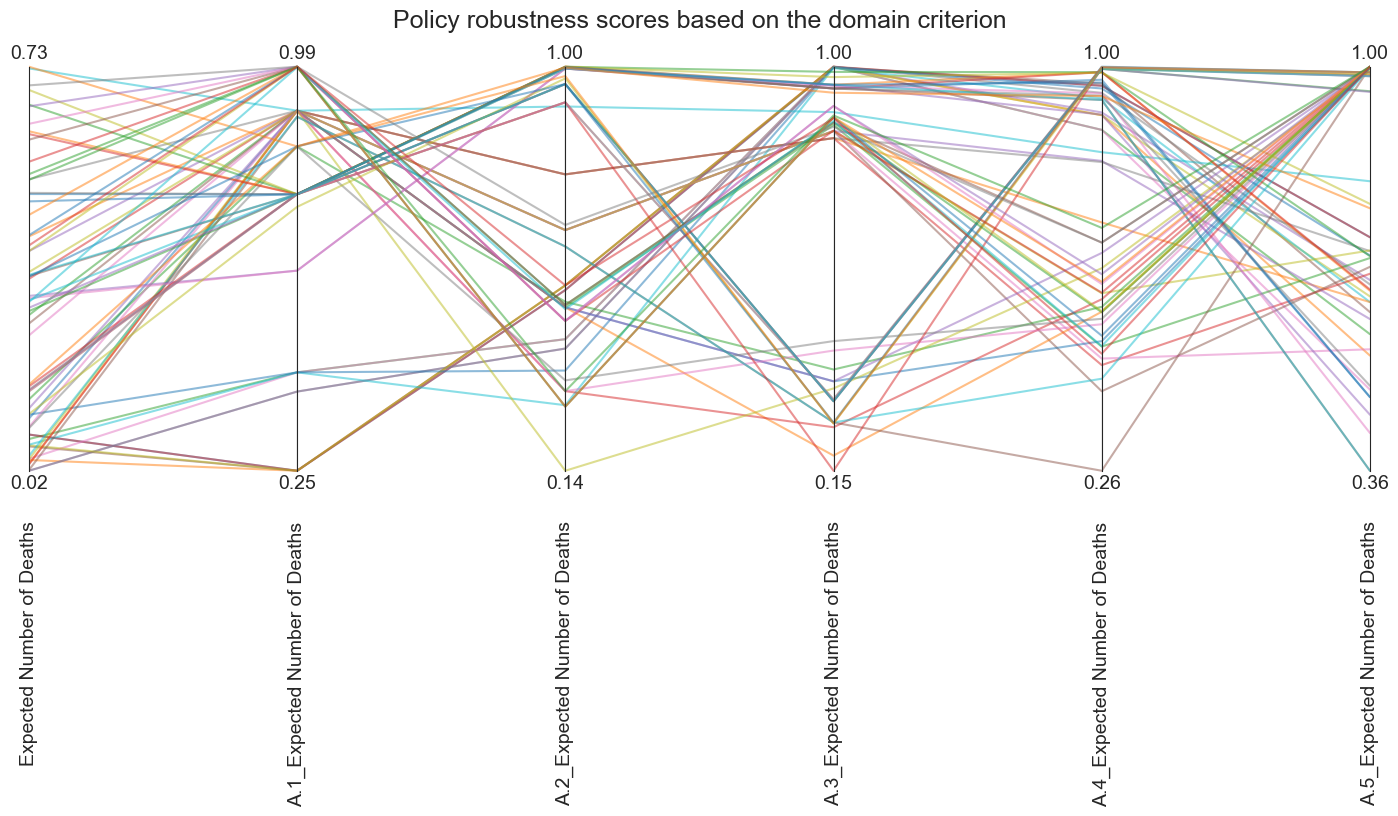

In [20]:
# Create parallel coordinate plot
limits = parcoords.get_limits(overall_scores)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(overall_scores, alpha=0.5)

# Save and show plot
fig = paraxes.fig
fig.set_size_inches(15,15)
fig.suptitle("Policy robustness scores based on the domain criterion", fontsize=18)
plt.savefig("figures/S4_parcoords_domain_criterion.png", dpi=300, bbox_inches='tight')
plt.show()

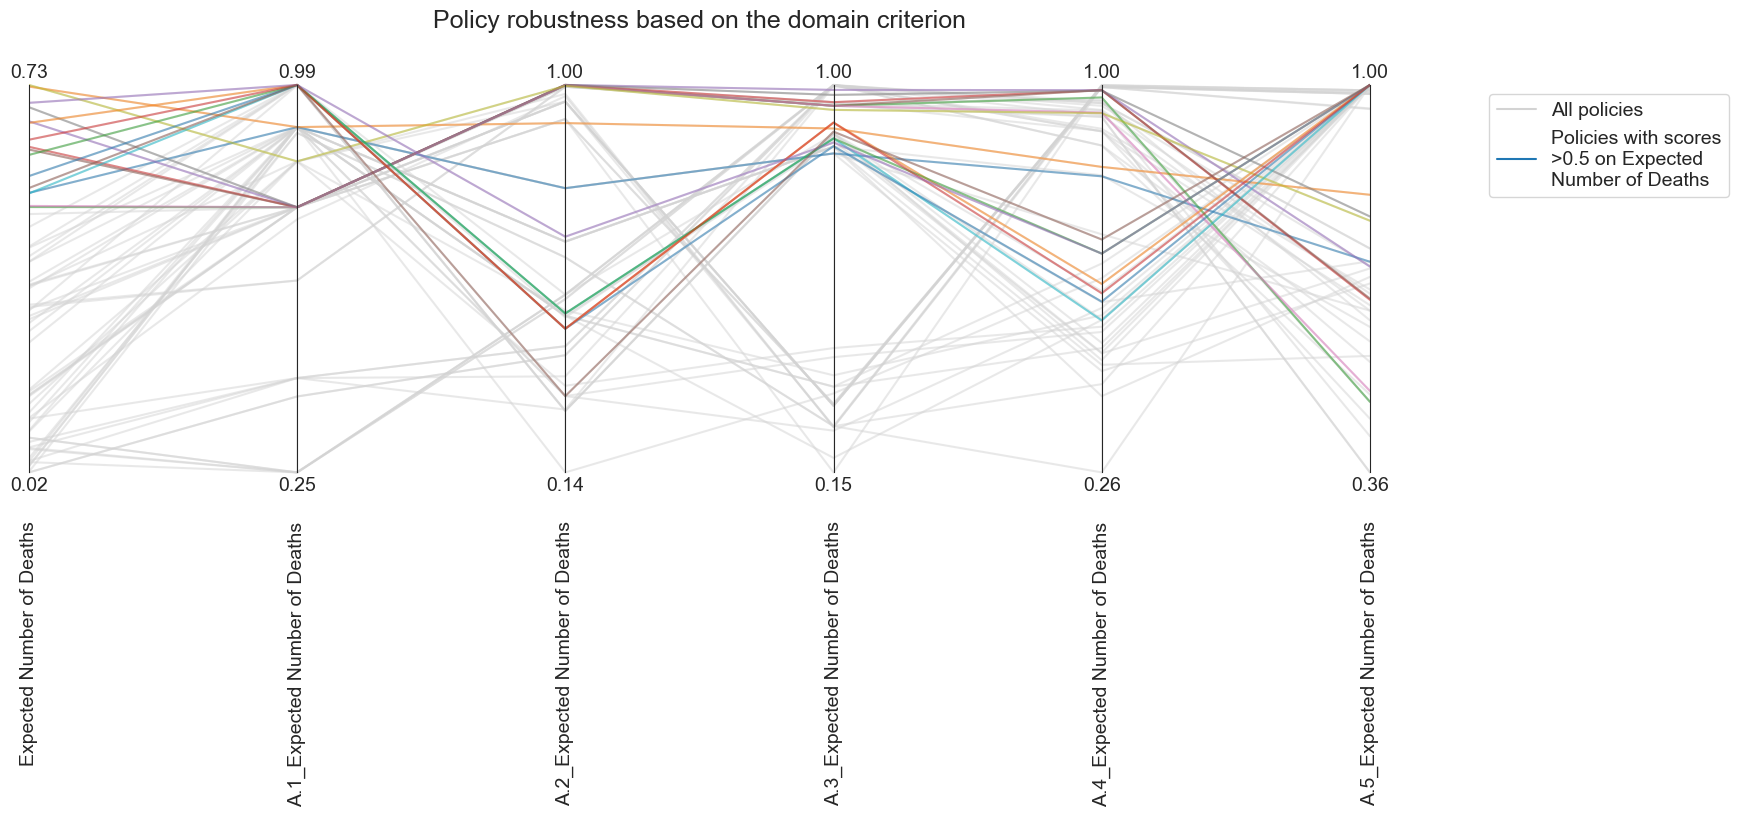

In [21]:
# Highlight those policies which are most robust on the total expected number of deaths
dc_robust_totaldeaths = overall_scores[overall_scores['Expected Number of Deaths']>0.5]

# Create parallel coordinate plot
limits = parcoords.get_limits(overall_scores)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(overall_scores, alpha=0.5, color='lightgrey', label = "All policies")
paraxes.plot(dc_robust_totaldeaths, alpha=0.5,
             label="Policies with scores" + "\n" + ">0.5 on Expected" + "\n" + "Number of Deaths")
paraxes.legend()

# Save and show plot
fig = paraxes.fig
fig.set_size_inches(15,15)
fig.suptitle("Policy robustness based on the domain criterion", fontsize=18)
plt.savefig("figures/S4_parcoords_domain_criterion_bestpolicies.png", dpi=300, bbox_inches='tight')
plt.show()

In [22]:
# Numbers of those policies
dc_robust_totaldeaths.index.values

array([17, 19, 30, 31, 32, 33, 37, 38, 41, 52, 53, 54, 55, 56, 57, 62],
      dtype=int64)

#### 4.5 Analysis 2: Maximum regret

In [23]:
# add scenarios and policies to the outcomes dataframe
outcomes = pd.DataFrame(outcomes)
outcomes['scenario'] = experiments.scenario   # regret is calculated by scenario
outcomes['policy'] = experiments.policy       # we want the max regret per policy

def calculate_regret(data): 
    # all outcomes should be minimized, so best performance is minimum
    zero_regrets = data.min(numeric_only=True)
    # regrets are calculated by subtracting the outcomes by the best performance
    regret = abs(np.subtract(data.loc[:, zero_regrets.index], zero_regrets))
    # add policy name to the regret
    regret['policy'] = data.policy
    # return the regret
    return regret

# calculate regret per scenario
regret = outcomes.groupby('scenario', group_keys=False).apply(calculate_regret)
# calculate the maximum regret for each policy
max_regret = regret.groupby('policy').max()

In [24]:
max_regret

,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths,A.1_Expected Annual Damage,A.1_Total Costs,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Total Costs,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Total Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Total Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Total Costs,A.5_Expected Number of Deaths,scenario
policy,,,,,,,,,,,,,,,,,,,
0,4.479651e+09,2.658751e+07,0.398001,4.057707e+09,4.015415e+09,0.300135,1.284378e+09,1.194386e+09,0.119012,2.270347e+07,2.030976e+07,0.005359,1.569917e+08,1.476761e+08,0.009262,1.407962e+09,1.391346e+09,0.161233,0.0
1,4.479651e+09,0.000000e+00,0.316973,4.057707e+09,4.015415e+09,0.240108,1.284378e+09,1.194386e+09,0.095209,0.000000e+00,2.391573e+07,0.000000,1.744920e+08,1.648013e+08,0.008703,1.461181e+09,1.416988e+09,0.138431,0.0
2,4.480808e+09,5.774488e+07,0.398750,4.006350e+09,3.985072e+09,0.300135,1.291212e+09,1.201220e+09,0.119028,0.000000e+00,2.391573e+07,0.000000,1.744920e+08,1.648013e+08,0.011024,1.351591e+09,1.332435e+09,0.173039,0.0
3,4.479651e+09,3.019348e+07,0.398001,4.057707e+09,4.015415e+09,0.300135,1.284378e+09,1.194386e+09,0.119012,0.000000e+00,2.391573e+07,0.000000,1.569917e+08,1.476761e+08,0.009262,1.407962e+09,1.391346e+09,0.161233,0.0
4,4.480808e+09,6.288792e+07,2.695030,4.006350e+09,3.985072e+09,2.000900,1.291212e+09,1.201220e+09,0.793522,0.000000e+00,2.391573e+07,0.000000,1.569917e+08,1.476761e+08,0.066009,1.407962e+09,1.391346e+09,1.108504,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,1.580346e+09,3.176690e+08,2.953116,0.000000e+00,7.629909e+07,1.733550,1.132148e+09,1.031295e+09,0.850783,1.601044e+09,1.591834e+09,2.954499,1.506894e+08,1.388661e+08,0.054666,0.000000e+00,5.817663e+07,0.000000,0.0
60,2.392213e+09,1.026208e+08,0.434249,0.000000e+00,7.629909e+07,0.000000,1.298832e+09,1.251659e+09,0.108046,2.463214e+09,2.450398e+09,0.438377,2.187025e+08,2.148796e+08,0.009681,0.000000e+00,9.676792e+07,0.000000,0.0
61,2.392213e+09,1.110520e+08,0.542410,0.000000e+00,7.629909e+07,0.059098,1.298832e+09,1.251659e+09,0.135057,2.463214e+09,2.450398e+09,0.547971,1.784547e+08,1.698906e+08,0.011183,0.000000e+00,9.676792e+07,0.000000,0.0


In [25]:
# Sort based on the policy number
max_regret = max_regret.set_index(max_regret.index.astype(int)).sort_index()
max_regret

,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths,A.1_Expected Annual Damage,A.1_Total Costs,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Total Costs,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Total Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Total Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Total Costs,A.5_Expected Number of Deaths,scenario
policy,,,,,,,,,,,,,,,,,,,
0,4.479651e+09,2.658751e+07,0.398001,4.057707e+09,4.015415e+09,0.300135,1.284378e+09,1.194386e+09,0.119012,2.270347e+07,2.030976e+07,0.005359,1.569917e+08,1.476761e+08,0.009262,1.407962e+09,1.391346e+09,0.161233,0.0
1,4.479651e+09,0.000000e+00,0.316973,4.057707e+09,4.015415e+09,0.240108,1.284378e+09,1.194386e+09,0.095209,0.000000e+00,2.391573e+07,0.000000,1.744920e+08,1.648013e+08,0.008703,1.461181e+09,1.416988e+09,0.138431,0.0
2,4.480808e+09,5.774488e+07,0.398750,4.006350e+09,3.985072e+09,0.300135,1.291212e+09,1.201220e+09,0.119028,0.000000e+00,2.391573e+07,0.000000,1.744920e+08,1.648013e+08,0.011024,1.351591e+09,1.332435e+09,0.173039,0.0
3,4.479651e+09,3.019348e+07,0.398001,4.057707e+09,4.015415e+09,0.300135,1.284378e+09,1.194386e+09,0.119012,0.000000e+00,2.391573e+07,0.000000,1.569917e+08,1.476761e+08,0.009262,1.407962e+09,1.391346e+09,0.161233,0.0
4,4.480808e+09,6.288792e+07,2.695030,4.006350e+09,3.985072e+09,2.000900,1.291212e+09,1.201220e+09,0.793522,0.000000e+00,2.391573e+07,0.000000,1.569917e+08,1.476761e+08,0.066009,1.407962e+09,1.391346e+09,1.108504,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,1.580346e+09,3.176690e+08,2.953116,0.000000e+00,7.629909e+07,1.733550,1.132148e+09,1.031295e+09,0.850783,1.601044e+09,1.591834e+09,2.954499,1.506894e+08,1.388661e+08,0.054666,0.000000e+00,5.817663e+07,0.000000,0.0
60,2.392213e+09,1.026208e+08,0.434249,0.000000e+00,7.629909e+07,0.000000,1.298832e+09,1.251659e+09,0.108046,2.463214e+09,2.450398e+09,0.438377,2.187025e+08,2.148796e+08,0.009681,0.000000e+00,9.676792e+07,0.000000,0.0
61,2.392213e+09,1.110520e+08,0.542410,0.000000e+00,7.629909e+07,0.059098,1.298832e+09,1.251659e+09,0.135057,2.463214e+09,2.450398e+09,0.547971,1.784547e+08,1.698906e+08,0.011183,0.000000e+00,9.676792e+07,0.000000,0.0


In [26]:
max_regret[(max_regret["Expected Annual Damage"] < max_regret["Expected Annual Damage"].mean()) & \
          (max_regret["Total Investment Costs"] < max_regret["Total Investment Costs"].mean()) &\
          (max_regret["Expected Number of Deaths"] < max_regret["Expected Number of Deaths"].mean())]

,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths,A.1_Expected Annual Damage,A.1_Total Costs,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Total Costs,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Total Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Total Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Total Costs,A.5_Expected Number of Deaths,scenario
policy,,,,,,,,,,,,,,,,,,,
11,3.701411e+09,3.777852e+07,0.540443,3.715021e+09,3.692694e+09,0.29920,1.162551e+09,1.055488e+09,0.127879,2.463214e+09,2.450398e+09,0.547971,1.909172e+08,1.801052e+08,0.011927,1.172496e+09,1.158654e+09,0.157445,0.0
12,3.701411e+09,1.612883e+07,0.434281,3.715021e+09,3.692694e+09,0.23936,1.221708e+09,1.170025e+09,0.107369,2.463214e+09,2.450398e+09,0.438377,2.209022e+08,2.134395e+08,0.009681,1.215705e+09,1.199090e+09,0.130009,0.0
13,3.701411e+09,2.769564e+07,0.432973,3.715021e+09,3.692694e+09,0.23936,1.162551e+09,1.055488e+09,0.101565,2.463214e+09,2.450398e+09,0.438377,2.224204e+08,2.134395e+08,0.009681,1.215705e+09,1.199090e+09,0.131544,0.0
14,3.701411e+09,3.284816e+07,0.540223,3.715021e+09,3.692694e+09,0.29920,1.162551e+09,1.065987e+09,0.132361,2.463214e+09,2.450398e+09,0.547971,1.780289e+08,1.683383e+08,0.011800,1.222351e+09,1.208509e+09,0.159885,0.0
15,3.701411e+09,2.162295e+07,0.541954,3.715021e+09,3.692694e+09,0.29920,1.162551e+09,1.065987e+09,0.132361,2.463214e+09,2.450398e+09,0.547971,2.224204e+08,2.134395e+08,0.012101,1.215705e+09,1.199090e+09,0.164375,0.0
16,3.701411e+09,1.910309e+07,0.432973,3.715021e+09,3.692694e+09,0.23936,1.162551e+09,1.065987e+09,0.105889,2.463214e+09,2.450398e+09,0.438377,2.224204e+08,2.134395e+08,0.009681,1.381815e+09,1.362658e+09,0.135889,0.0
17,3.701411e+09,4.192528e+07,0.540223,3.715021e+09,3.692694e+09,0.29920,1.162551e+09,1.055488e+09,0.127879,2.463214e+09,2.450398e+09,0.547971,1.780289e+08,1.683383e+08,0.011927,9.444883e+08,9.336719e+08,0.146396,0.0
18,3.701411e+09,3.071620e+07,0.541000,3.715021e+09,3.692694e+09,0.29920,1.162551e+09,1.065987e+09,0.132361,2.463214e+09,2.450398e+09,0.547971,2.074477e+08,2.011821e+08,0.011800,1.147029e+09,1.133187e+09,0.153524,0.0
19,3.701411e+09,6.192908e+07,0.264054,3.715021e+09,3.692694e+09,0.23936,1.162551e+09,1.069393e+09,0.101565,1.479285e+09,1.469292e+09,0.269274,1.785918e+08,1.689012e+08,0.009601,6.664780e+08,6.589612e+08,0.091267,0.0


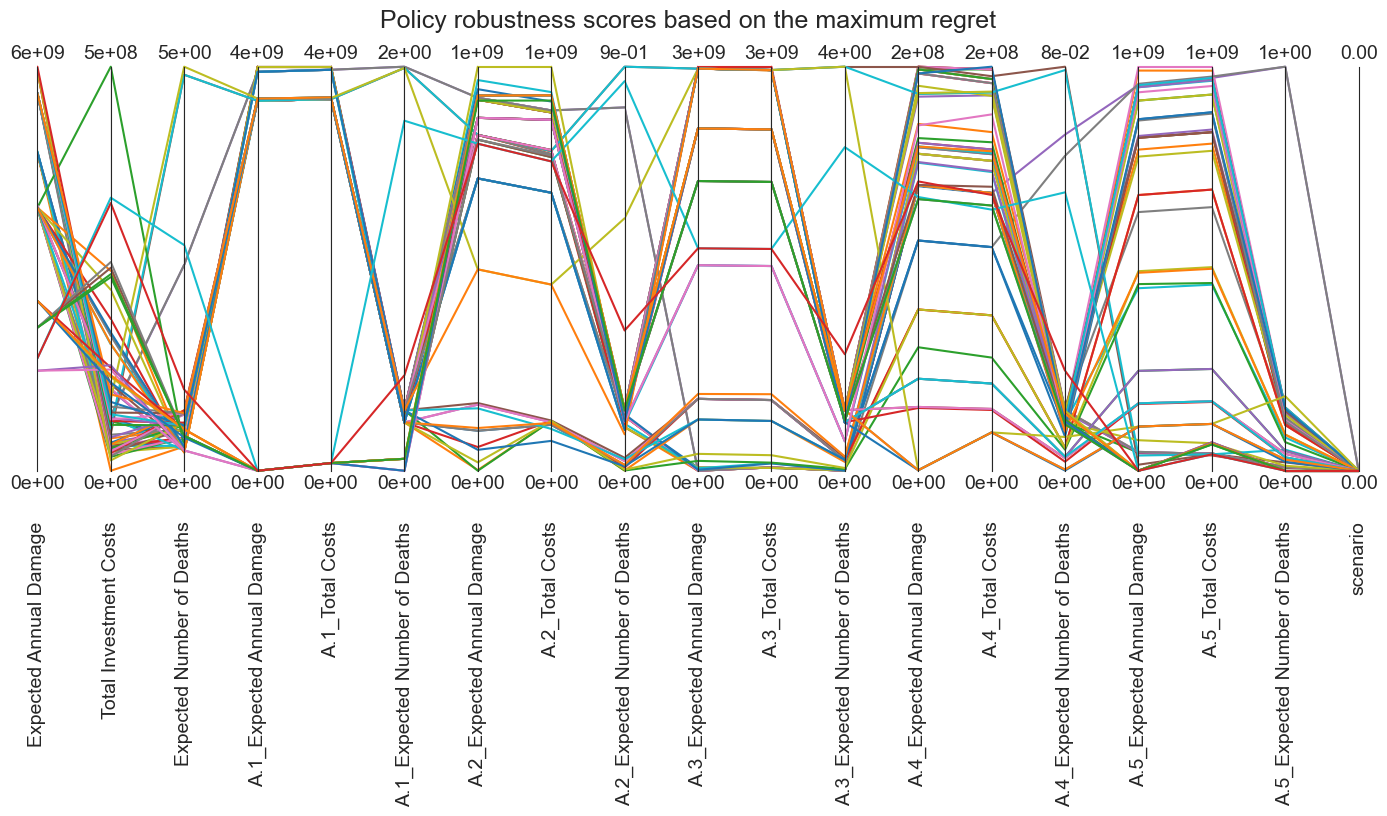

In [27]:
# Visualize the max regret using a parallel coordinate plot
limits = parcoords.get_limits(max_regret)
limits.loc[0, [o.name for o in dike_model.outcomes]] = 0
colors = sns.color_palette()

# Initiate plot
paraxes = parcoords.ParallelAxes(limits, formatter={o.name:".0e" for o in dike_model.outcomes})
colors = sns.color_palette()
for i, (policy, outcomes) in enumerate(max_regret.iterrows()):
    paraxes.plot(outcomes.to_frame().T, label='Policy {}'.format(policy)) #, color=colors[i])
#paraxes.legend()

# show plot
fig = paraxes.fig
fig.set_size_inches(15,15)
fig.suptitle("Policy robustness scores based on the maximum regret", fontsize=18)
plt.savefig("figures/S4_parcoords_max_regret.png", dpi=300, bbox_inches='tight')
plt.show()

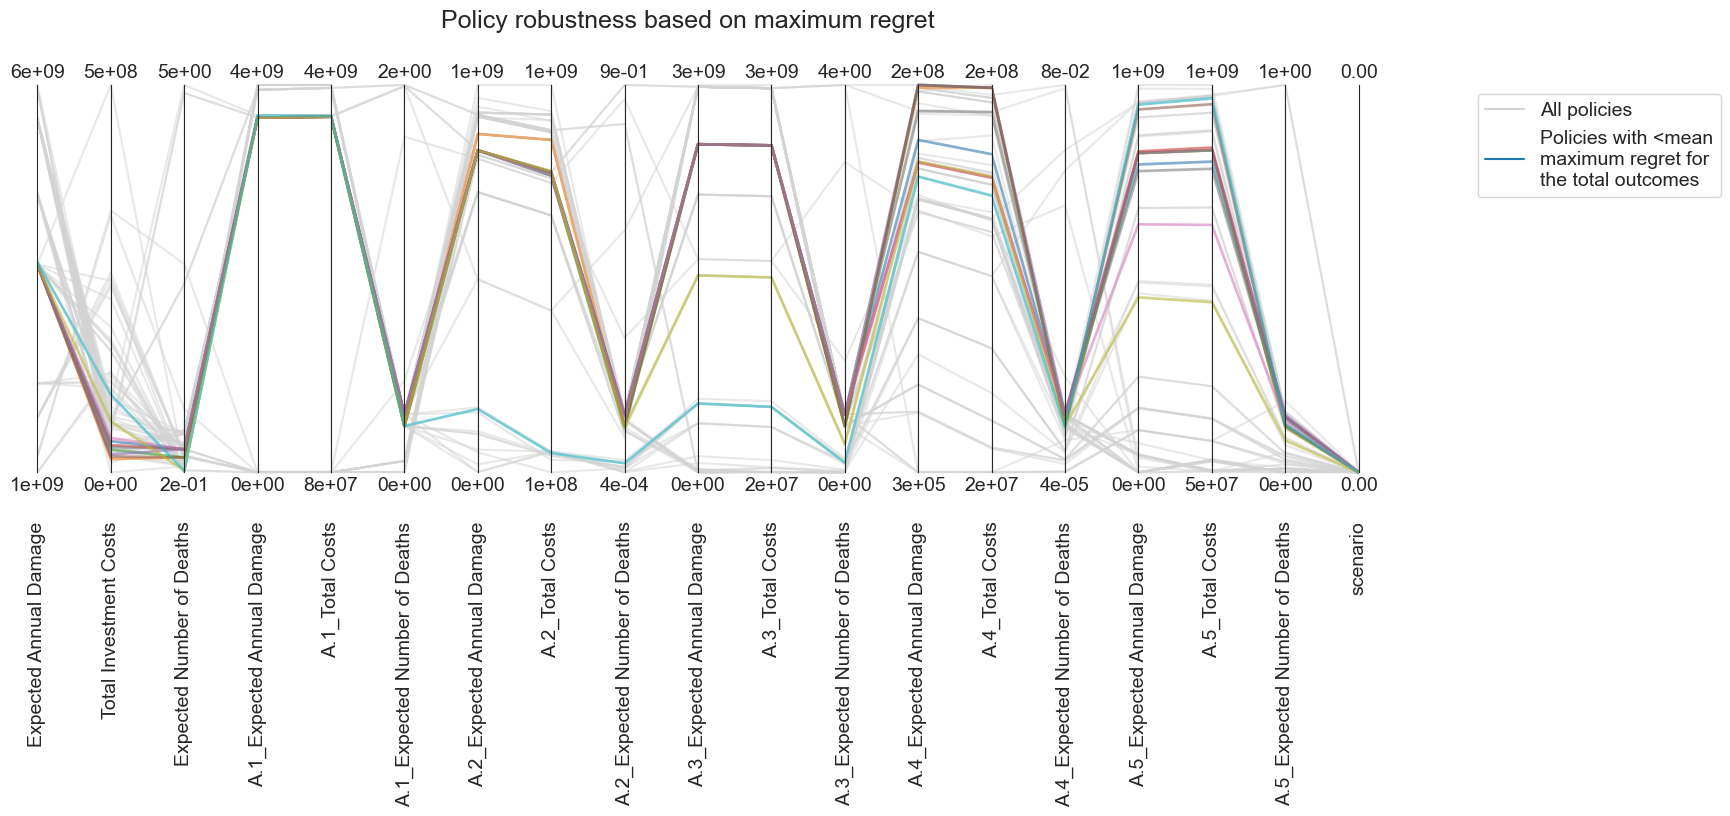

In [28]:
# Highlight those policies which are most robust on the total expected number of deaths
mr_robust_totals = max_regret[(max_regret["Expected Annual Damage"] < max_regret["Expected Annual Damage"].mean()) & \
          (max_regret["Total Investment Costs"] < max_regret["Total Investment Costs"].mean()) &\
          (max_regret["Expected Number of Deaths"] < max_regret["Expected Number of Deaths"].mean())]

# Create parallel coordinate plot
limits = parcoords.get_limits(max_regret)
paraxes = parcoords.ParallelAxes(limits, formatter={o.name:".0e" for o in dike_model.outcomes})
paraxes.plot(max_regret, alpha=0.5, color='lightgrey', label = "All policies")
paraxes.plot(mr_robust_totals, alpha=0.5, linewidth = 2,
             label="Policies with <mean" + "\n" + "maximum regret for" + "\n" + "the total outcomes")
paraxes.legend()

# Save and show plot
fig = paraxes.fig
fig.set_size_inches(15,15)
fig.suptitle("Policy robustness based on maximum regret", fontsize=18)
plt.savefig("figures/S4_parcoords_max_regret_bestpolicies.png", dpi=300, bbox_inches='tight')
plt.show()

In [29]:
# Numbers of those policies
mr_robust_totals.index.values

array([11, 12, 13, 14, 15, 16, 17, 18, 19, 34])

In [30]:
# Comapre with the domain criterion robust policies
dc_robust_totaldeaths.index.values

array([17, 19, 30, 31, 32, 33, 37, 38, 41, 52, 53, 54, 55, 56, 57, 62],
      dtype=int64)

#### 4.6 Analyse overall robustness: heatmap of scores per policy

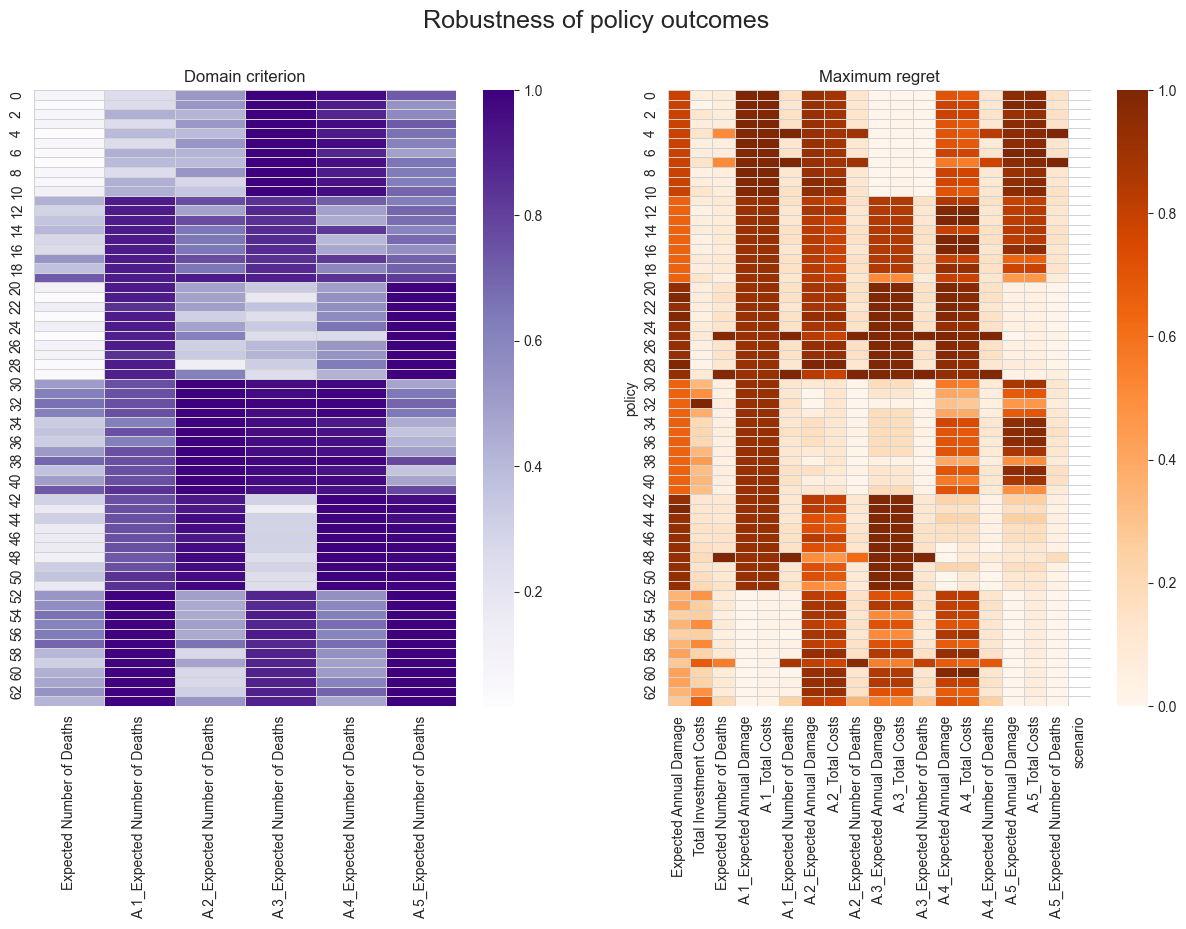

In [31]:
# Plot the levers present in the selected policies
fig, ax = plt.subplots(1,2, figsize=(15,8)) 

# Plot the policies robustness
sns.heatmap(overall_scores, cmap='Purples', ax=ax[0], linewidths=0.5, linecolor='lightgrey')
ax[0].set_title('Domain criterion')

# Plot the policies maximum regret
sns.heatmap(max_regret/max_regret.max(), cmap='Oranges', ax=ax[1], linewidths=0.5, linecolor='lightgrey')
ax[1].set_title('Maximum regret')

# Save and show figure
fig.suptitle("Robustness of policy outcomes", fontsize=18)
plt.savefig("figures/S4_heatmap_policy_robustness.png", dpi=300, bbox_inches='tight')
plt.show()

#### 4.7 Select policies for scenario discovery?

In [29]:
# Best policies based on max regret?
mr_robust_totals.index.values

array([11, 12, 13, 14, 15, 16, 17, 18, 19, 34])

In [30]:
# Best policies based on domain criterion?
dc_robust_totaldeaths.index.values

array([17, 19, 30, 31, 32, 33, 37, 38, 41, 52, 53, 54, 55, 56, 57, 62],
      dtype=int64)

## Step 5. Scenario Discovery
#### *See script: G11_S5_ScenarioDiscovery.ipynb*